# Survival output test
Testare il predict dei modelli, vorrei avere una predizione a piu' tempi sensata per i modelli che la supportano. Sarebbe carino anche sapere che tipo di output e', perche' per esempio antolini dovrebbe prendere una survival, altre metriche magari hanno bisogno di altro?

Magari si puo' mettere altri metodi, tipo predict_survival, predict_failure, predict_hazard e predict_density per i metodi che lo supportano, con il predict normale che resta generico. Per farlo bisognerebbe esaminare ad uno ad uno i vari metodi

In [1]:
import numpy
import pandas
import sklearn

In [2]:
import survwrap

In [3]:
X, y = survwrap.load_test_data()
X.shape, y.shape

((198, 84), (198,))

In [4]:
etimes = numpy.sort(survwrap.get_time(y)[survwrap.get_indicator(y)])
etimes

array([ 125.,  269.,  289.,  394.,  404.,  421.,  434.,  524.,  528.,
        530.,  649.,  690.,  723.,  730.,  794.,  796.,  803.,  805.,
        880.,  910.,  994., 1023., 1112., 1136., 1171., 1206., 1233.,
       1259., 1598., 1693., 1721., 1731., 1742., 1743., 1815., 2349.,
       2454., 2604., 2863., 3121., 3313., 3822., 3976., 4050., 4066.,
       4212., 4353., 4415., 4618., 6777., 7185.])

In [5]:
ltime = numpy.linspace(0, etimes.max() * 1.1, num=100)

In [6]:
def plot_output(method, X, time):
    pred = method(X, time)
    #print(pred.shape, X.shape, time.shape)
    pred = pandas.DataFrame(
        pred, 
        index=X.index if hasattr(X, 'index') else [f'Ind{i}' for i, _ in enumerate(X)],
        columns=pandas.Index(time, name='time'),
    )

    pred.T.plot()

In [7]:
# uses global data!
def test_model(m):
    # times must be sorted (monotonicity check)
    assert m.predict(X).shape == (len(X),)

    surv = m.predict_survival(X, etimes[0])
    assert surv.shape == (len(X),)

    surv = m.predict_survival(X, etimes)
    assert surv.shape == (len(X), len(etimes)), f'bad predicted survival probability shape {surv.shape}, expected {(len(X), len(etimes))}'
    assert surv.min() >= 0.0, f'found {(surv < 0).mean():.%} negative values in predicted survival probabilities'
    assert surv.max() <= 1.0, f'{(surv > 1).mean():.%} of predicted survival probabilities are greater than 1'
    assert numpy.diff(surv).max() <= 0.0, 'survival monotonicity failure'

    #fail = m.predict_failure(X, etimes)
    #err = 1.0 - surv - fail
    #assert (numpy.abs(err) < 0.0000001).all()

## CoxNet

In [8]:
coxnet = survwrap.CoxNet(rng_seed=2309)
coxnet.fit(X, y)

CoxNet(rng_seed=2309, alpha=None, l1_ratio=0.5)

In [9]:
test_model(coxnet)

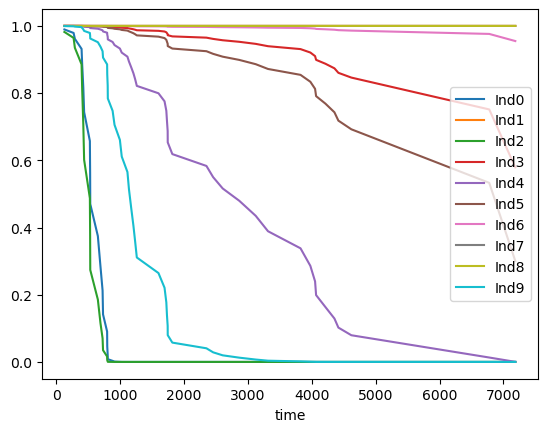

In [10]:
plot_output(coxnet.predict_survival, X[:10], etimes)

In [11]:
#plot_output(coxnet.model_.predict_cumulative_hazard_function, X[:10], etimes)

## DeepHit

Fixme model should run without arguments, gives an error about the seed

In [12]:
try:
    deephit = survwrap.DeepHitSingle()
    deephit.fit(X, y)
except ValueError as e:
    print(e)
    print('model should work without parameters!')

Seed must be between 0 and 2**32 - 1
model should work without parameters!


In [13]:
deephit = survwrap.DeepHitSingle(rng_seed=0, epochs=1)
deephit.fit(X, y)

/usr/local/ivan/Unito/conda/envs/hive/lib/python3.8/site-packages/torchtuples/callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817693763/work/torch/csrc/utils/python_arg_parser.cpp:1174.)
  p.data = p.data.add(-weight_decay * eta, p.data)


DeepHitSingle(rng_seed=0, num_durations=10, layer_sizes=[10, 10], epochs=1, batch_size=16, validation_size=0.1, learning_rate=0.001, dropout=0.1, device='cpu')

In [46]:
test_model(deephit)

In [15]:
#plot_output(deephit.predict_failure, X[:10], etimes)

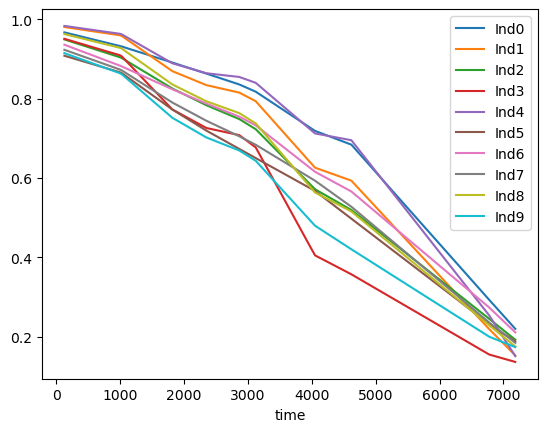

In [47]:
plot_output(deephit.predict_survival, X[:10], etimes)

In [17]:
deephit.predict(X[:10])

array([0.30174074, 0.3932494 , 0.45913287, 0.62302185, 0.29780571,
       0.47373242, 0.41356371, 0.44540988, 0.46460147, 0.55515354])

## Auton

In [48]:
survmach = survwrap.DeepSurvivalMachines(max_epochs=10)
survmach.fit(X, y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 73.61it/s]


DeepSurvivalMachines(rng_seed=-1, n_distr=2, distr_kind='Weibull', batch_size=32, layer_sizes=[10, 10], learning_rate=0.001, validation_size=0.1, max_epochs=10, elbo=False)

In [49]:
test_model(survmach)


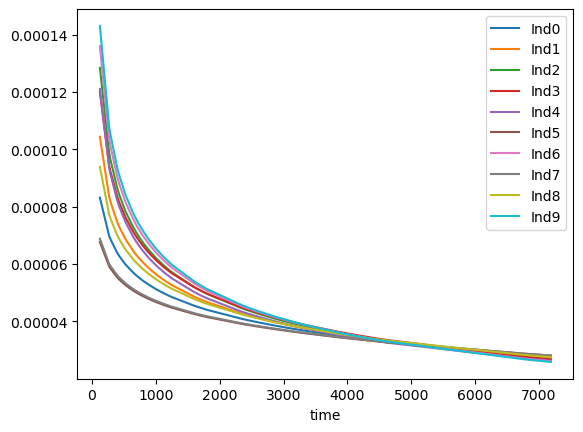

In [50]:
plot_output(survmach.model_.predict_pdf, X[:10], etimes.tolist())

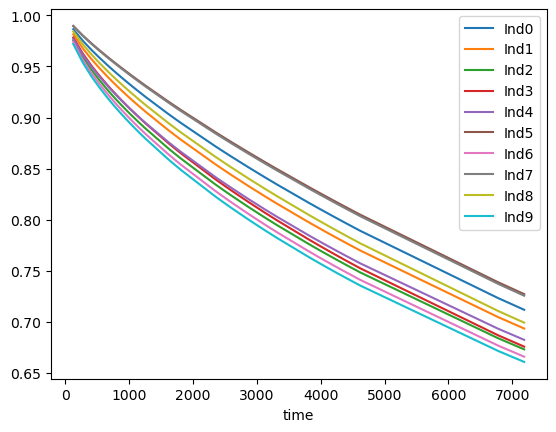

In [21]:
plot_output(survmach.model_.predict_survival, X[:10], etimes.tolist())

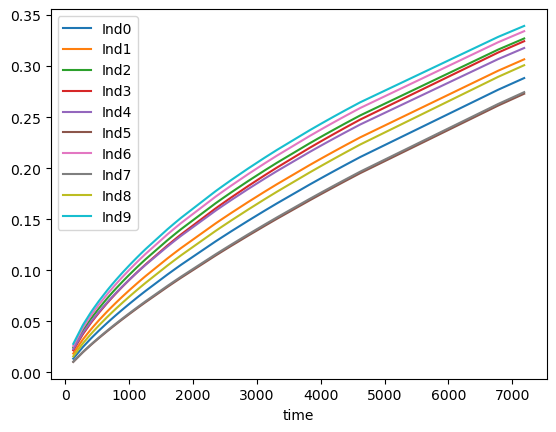

In [22]:
plot_output(survmach.model_.predict_risk, X[:10], etimes.tolist())

## Survtrace

In [51]:
strace= survwrap.SurvTraceSingle(rng_seed=2310)
strace.fit(X,y)

/usr/local/ivan/Unito/conda/envs/hive/lib/python3.8/site-packages/survtrace/utils.py:78: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


GPU not found! will use cpu for training!
[Train-0]: 6.252183437347412
[Val-0]: 1.7810970544815063
[Train-1]: 6.044994354248047
[Val-1]: 1.1964707374572754
[Train-2]: 5.731592059135437
[Val-2]: 0.9420523643493652
[Train-3]: 5.354802250862122
[Val-3]: 1.0691486597061157
EarlyStopping counter: 1 out of 5
[Train-4]: 4.84684956073761
[Val-4]: 1.3161211013793945
EarlyStopping counter: 2 out of 5
[Train-5]: 4.258486390113831
[Val-5]: 2.3267464637756348
EarlyStopping counter: 3 out of 5
[Train-6]: 3.7075212001800537
[Val-6]: 2.7614216804504395
EarlyStopping counter: 4 out of 5
[Train-7]: 3.1421616077423096
[Val-7]: 3.300579071044922
EarlyStopping counter: 5 out of 5
early stops at epoch 8


SurvTraceSingle(rng_seed=2310, num_durations=5, horizons=[0.25, 0.5, 0.75], hidden_size=16, intermediate_size=64, num_hidden_layers=3, num_attention_heads=2, validation_size=0.1)

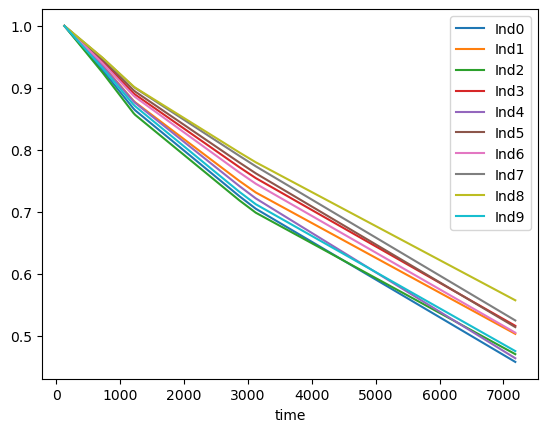

In [53]:
plot_output(strace.predict_survival, X[:10], etimes.tolist())

## Concordance index
Ho esteso l'implementazione del c-index di sksurv per rishio dipendente dal tempo, non mi e' chiaro se otteniamo antolini o qualcosa diverso...

Nello scorer uso la probabilita' cumulativa come rishio.

In [54]:
import sksurv
from survwrap.util import get_indicator, get_time
from sklearn.metrics import make_scorer

In [55]:
from survwrap.metrics import concordance_index_score
from survwrap.metrics import concordance_index_td_scorer

In [56]:
# coxnet must return the same for both scores, since its prediction is time independent
s = make_scorer(concordance_index_score, return_all=True)
for m in [strace, survmach, deephit, coxnet]:
    print(s(m, X, y))
s = lambda *args: concordance_index_td_scorer(*args, return_all=True)
for m in [strace,survmach, deephit, coxnet]:
    print(s(m, X, y))

(0.8170685519505113, 6472, 1449, 0, 0)
(0.5678575937381644, 4498, 3423, 0, 0)
(0.3922484534780962, 3107, 4814, 0, 0)
(0.9462189117535664, 7495, 426, 0, 0)
(0.8029920464587804, 6262, 1462, 197, 0)
(0.5687413205403358, 4505, 3416, 0, 0)
(0.4259563186466355, 3374, 4547, 0, 0)
(0.9462189117535664, 7495, 426, 0, 0)


## Brier

In [57]:
from survwrap.metrics import brier_score
from survwrap.metrics import make_time_dependent_scorer

In [58]:
ev_quantiles=survwrap.event_quantiles(y, quantiles=[0.1,0.25,0.4,0.5,0.6,0.75])
ev_quantiles

array([ 421. ,  726.5,  994. , 1206. , 1721. , 2733.5])

In [59]:
# score for all event times
brier_score(y, 1 - coxnet.predict_survival(X, etimes), etimes)

0.02420507883330261

In [60]:
# score at specified time quantiles
brier_score(y, 1 - coxnet.predict_survival(X, ev_quantiles), ev_quantiles)

0.0205450645622881

In [61]:
# score for single time
brier_score(y, 1 - coxnet.predict_survival(X, etimes[20]), etimes[20])

0.013785050849962477

In [62]:
# sksurv version of brier, this one accounts for censoring probabilities so it is slightly different from my implementation of the naive brier_score
sksurv.metrics.brier_score(y, y, coxnet.predict_survival(X, etimes[20]), etimes[20])

(array([994.]), array([0.01375474]))

In [63]:
s = make_time_dependent_scorer(brier_score,time_mode='quantiles', time_values=[0.1,0.25,0.4,0.5,0.6,0.75])
for m in [strace,survmach, deephit, coxnet]:
    print(s(m, X, y))

0.09536945100995556
0.09876710101565622
0.10693359106262343
0.0205450645622881


## AUC

In [69]:
from survwrap.metrics import make_time_dependent_classification_score
roc_auc_td_score = make_time_dependent_classification_score(sklearn.metrics.roc_auc_score)
roc_auc_td_score
#roc_auc_td_score(y, 1 - coxnet.predict_survival(X, etimes[20]), etimes[20]), roc_auc_td_score(y, 1 - coxnet.predict_survival(X, etimes), etimes)

<function survwrap.metrics.make_time_dependent_classification_score.<locals>.td_score(y_true, y_pred, times, **kwargs)>

In [65]:
s = make_time_dependent_scorer(roc_auc_td_score)
for m in [strace,survmach, deephit, coxnet]:
    print(s(m, X, y))


0.846112659028944
0.5887875965186244
0.45463159816848175
0.9763924588024728


In [66]:
s


<function survwrap.metrics.make_time_dependent_scorer.<locals>.scorer(estimator, X, y)>

In [67]:
s = make_time_dependent_scorer(roc_auc_td_score, time_mode='absolute', time_values=numpy.quantile(etimes, [0.25, 0.5, 0.75]))
for m in [strace,survmach, deephit, coxnet]:
    print(s(m, X, y))
print('----')
s = make_time_dependent_scorer(roc_auc_td_score, time_mode='quantiles', time_values=[0.1, 0.25,0.4, 0.5, 0.6,0.75])
for m in [strace, survmach, deephit, coxnet]:
    print(s(m, X, y))

0.8753215313685638
0.6222755435455521
0.43766440050281696
0.9757171890694057
----
0.8626394431075157
0.6300470304501798
0.4583900531661162
0.9808023368736065


In [39]:
#survwrap.optimize(deephit, X, y, )

## Antolini
Tentativo di recuperare antolini da pycox, non cosi' semplice

In [70]:
import pycox
def antolini_scorer(estimator, X, y):
    surv = estimator.predict_survival(X, get_time(y))
    return pycox.evaluation.concordance.concordance_td(
        durations=get_time(y), events=get_indicator(y),
        surv=surv, surv_idx=numpy.arange(len(X)),
    )

for m in [strace, survmach, deephit, coxnet]:
    #survmach.predict_survival(X[:10], etimes[0])
    s = antolini_scorer(m, X, y)
    print(s)

0.0
0.0
0.0
0.009279131422800152


In [41]:
surv = deephit.model_.interpolate(10).predict_surv_df(X.astype('float32'))
surv

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
0,0.971801,0.983310,0.955518,0.956615,0.985961,0.913979,0.943364,0.930108,0.967562,0.921827,...,0.970672,0.847616,0.938710,0.958329,0.946978,0.959650,0.969033,0.924291,0.875786,0.978574
1,0.967801,0.980892,0.950293,0.951787,0.983654,0.909135,0.937224,0.924325,0.963533,0.915935,...,0.967031,0.841920,0.932184,0.954518,0.940758,0.954638,0.964706,0.917505,0.869423,0.976260
2,0.963802,0.978474,0.945067,0.946959,0.981347,0.904291,0.931084,0.918541,0.959505,0.910043,...,0.963389,0.836223,0.925657,0.950706,0.934538,0.949626,0.960379,0.910720,0.863061,0.973946
3,0.959803,0.976057,0.939842,0.942131,0.979040,0.899448,0.924944,0.912758,0.955476,0.904151,...,0.959747,0.830527,0.919131,0.946895,0.928318,0.944614,0.956052,0.903935,0.856699,0.971632
4,0.955803,0.973639,0.934616,0.937303,0.976734,0.894604,0.918805,0.906974,0.951448,0.898259,...,0.956105,0.824831,0.912604,0.943083,0.922098,0.939602,0.951725,0.897149,0.850336,0.969318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.120469,0.083630,0.095917,0.062123,0.079250,0.109704,0.108122,0.102048,0.088351,0.094145,...,0.077164,0.110972,0.078349,0.089880,0.087199,0.079909,0.099729,0.106276,0.109953,0.096815
87,0.110551,0.078863,0.091297,0.059593,0.073795,0.101666,0.102082,0.096105,0.084298,0.088443,...,0.073924,0.106026,0.075316,0.085151,0.083126,0.076169,0.093367,0.100185,0.101617,0.092578
88,0.100632,0.074096,0.086677,0.057063,0.068341,0.093628,0.096042,0.090163,0.080245,0.082740,...,0.070684,0.101079,0.072283,0.080421,0.079053,0.072430,0.087005,0.094095,0.093280,0.088342
89,0.090714,0.069330,0.082056,0.054533,0.062887,0.085589,0.090002,0.084220,0.076191,0.077038,...,0.067444,0.096133,0.069250,0.075692,0.074980,0.068690,0.080643,0.088005,0.084943,0.084105


In [42]:
surv = deephit.predict_survival(X, get_time(y))
# samples x times
surv.shape

(198, 198)

In [71]:
for m in [strace,survmach, deephit, coxnet]:
    s = make_scorer(concordance_index_score)(m, X, y)
    print(s)

0.8170685519505113
0.5678575937381644
0.3922484534780962
0.9462189117535664


In [44]:
pycox.evaluation.EvalSurv(surv, get_time(y), get_indicator(y), censor_surv='km')

AttributeError: 'Series' object has no attribute 'is_monotonic'

In [ ]:
pandas.__version__